# Flower Recognition CNN Keras

## [ Please upvote / star if you like it ;)  ]

In [2]:
#import os
#print(os.listdir('/kaggle/input/flowers-recognition'))

<a id="content1"></a>
## 1 ) Importing Various Modules.

In [26]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

<a id="content2"></a>
## 2 ) Preparing the Data

## 2.1) Making the functions to get the training and validation set from the Images

In [27]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='../input/flowers-recognition/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../input/flowers-recognition/flowers/sunflower'
FLOWER_TULIP_DIR='../input/flowers-recognition/flowers/tulip'
FLOWER_DANDI_DIR='../input/flowers-recognition/flowers/dandelion'
FLOWER_ROSE_DIR='../input/flowers-recognition/flowers/rose'
print("Done")


Done


In [28]:
def assign_label(img,flower_type):
    return flower_type
    

In [29]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [30]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 764/764 [00:03<00:00, 247.44it/s]

764


In [31]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:03<00:00, 208.58it/s]

1497


In [32]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:04<00:00, 243.13it/s]

2481


In [33]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:04<00:00, 234.13it/s]

3533


In [34]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:03<00:00, 231.45it/s]

4317


## 2.2 ) Visualizing some Random Images

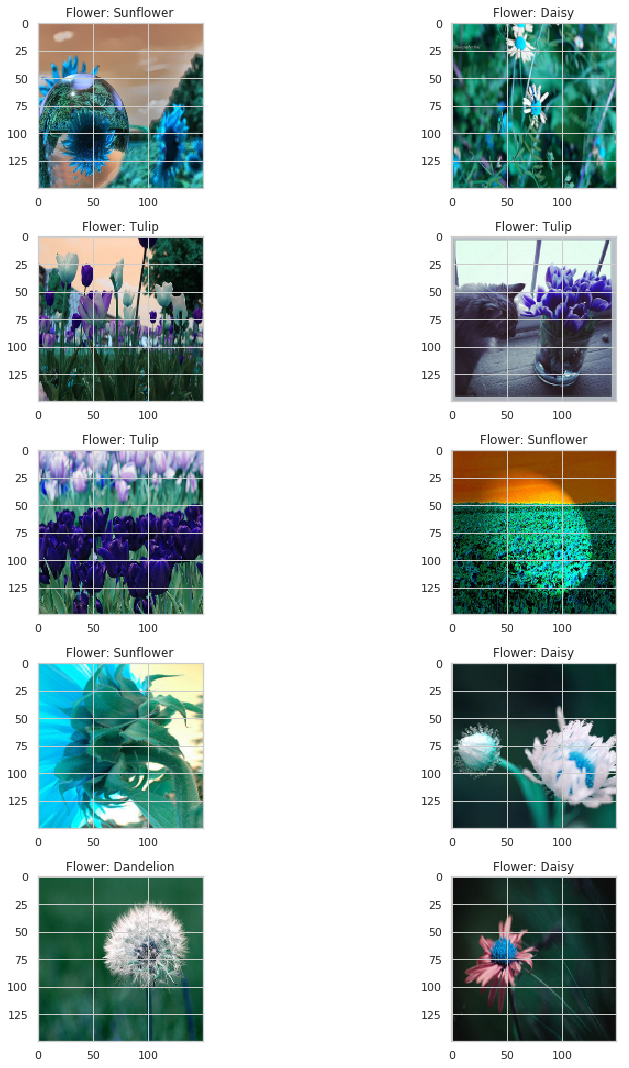

In [35]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

## 2.3 ) Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [36]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

## 2.4 ) Splitting into Training and Validation Sets

In [37]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


## 2.5 ) Setting the Random Seeds

In [38]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

<a id="content3"></a>
## 3 ) Modelling

## 3.1 ) Building the ConvNet Model

In [39]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

## 3.2 ) Using a LR Annealer

In [40]:
batch_size=128
epochs=10

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

## 3.3 ) Data Augmentation to prevent Overfitting

In [41]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## 3.4 ) Compiling the Keras Model & Summary

In [42]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 18, 96)        83040     
__________

## 3.5 ) Fitting on the Training set and making predcitons on the Validation set

In [45]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/10
25/25 [==============================] - 221s 9s/step - loss: 1.4836 - acc: 0.3350 - val_loss: 1.1824 - val_acc: 0.5269
Epoch 2/10
25/25 [==============================] - 212s 8s/step - loss: 1.1959 - acc: 0.4952 - val_loss: 1.0621 - val_acc: 0.5917
Epoch 3/10
25/25 [==============================] - 212s 8s/step - loss: 1.0899 - acc: 0.5536 - val_loss: 1.0634 - val_acc: 0.5787
Epoch 4/10
25/25 [==============================] - 212s 8s/step - loss: 1.0426 - acc: 0.5893 - val_loss: 0.9743 - val_acc: 0.6269
Epoch 5/10
25/25 [==============================] - 213s 9s/step - loss: 0.9907 - acc: 0.5850 - val_loss: 1.0214 - val_acc: 0.5954
Epoch 6/10
25/25 [==============================] - 219s 9s/step - loss: 0.9559 - acc: 0.6186 - val_loss: 0.9368 - val_acc: 0.6278
Epoch 7/10
25/25 [==============================] - 219s 9s/step - loss: 0.9118 - acc: 0.6445 - val_loss: 0.8688 - val_acc: 0.6759
Epoch 8/10
25/25 [==============================] - 218s 9s/step - loss: 0.8741 - a

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

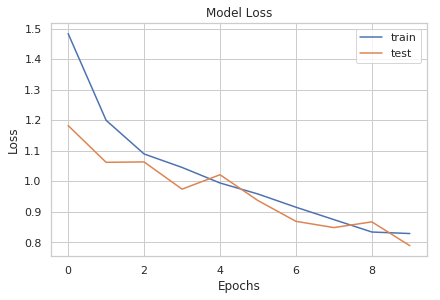

In [46]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

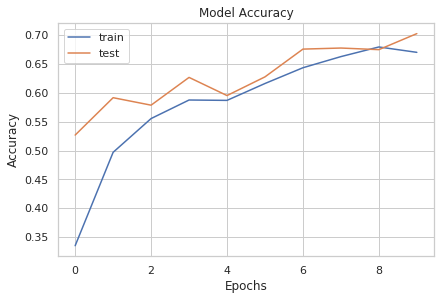

In [47]:
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()


<a id="content5"></a>
## 5 ) Visualizing Predictons on the Validation Set

In [49]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [50]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

#### CORRECTLY CLASSIFIED FLOWER IMAGES

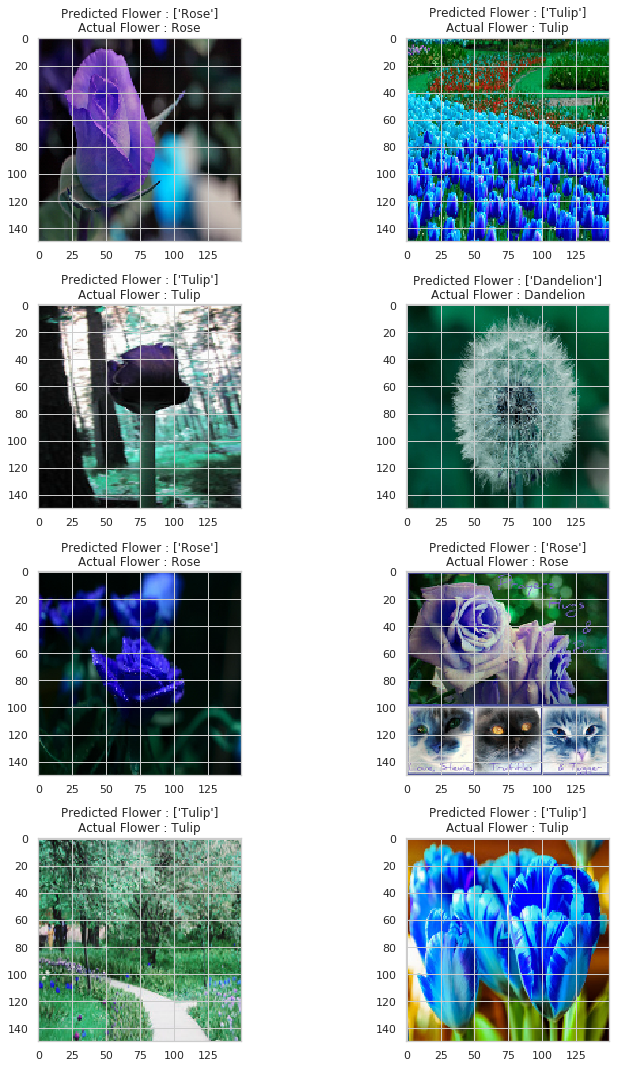

In [51]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

#### MISCLASSIFIED IMAGES OF FLOWERS

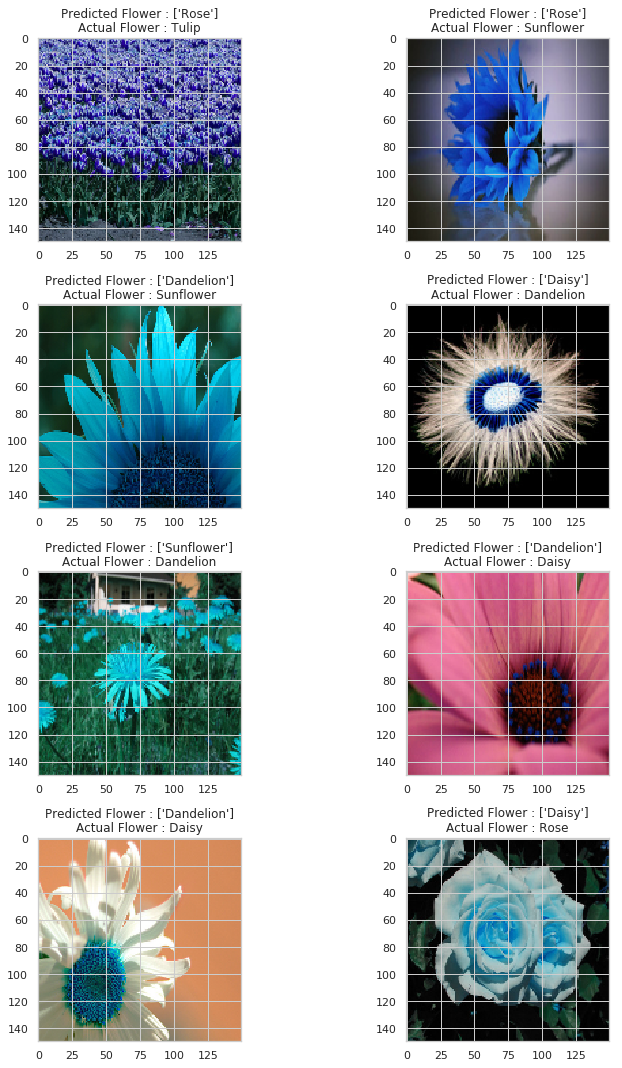

In [52]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1

In [ ]:
!pip install -U scikit-learn


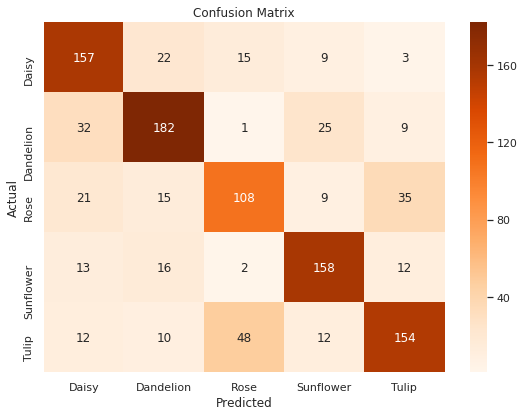

Classification Report:

             precision    recall  f1-score   support

      Daisy       0.67      0.76      0.71       206
  Dandelion       0.74      0.73      0.74       249
       Rose       0.62      0.57      0.60       188
  Sunflower       0.74      0.79      0.76       201
      Tulip       0.72      0.65      0.69       236

avg / total       0.70      0.70      0.70      1080

ROC AUC can't be computed due to dimensionality issue.


In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Convert predictions and true labels to class indices
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# ROC AUC Score (for multi-class)
from sklearn.metrics import roc_auc_score
try:
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f"\nOverall ROC AUC Score: {auc:.4f}")
except:
    print("ROC AUC can't be computed due to dimensionality issue.")



In [55]:
from tensorflow.keras.preprocessing import image

def predict_custom_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # same as model input
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_label = le.inverse_transform([np.argmax(prediction)])

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label[0]}")
    plt.show()


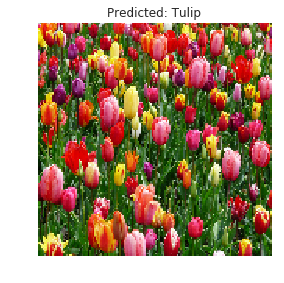

In [58]:
predict_custom_image('/kaggle/input/flowers/pexels-pixabay-69776.jpg')
